In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import geopandas as gpd
import asf_search as asf
import contextily as cx
import numpy as np
import fiona
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from osgeo import gdal

from ARIAtools.contrib.product.utils import get_union_extent, ds_get_extent
from ARIAtools.contrib.product.dataframe import get_df_d12stats
from ARIAtools.contrib.product.plotting import plot_network, plot_pairing, hist_stats, plot_gaps

# new functions
from ARIAtools.contrib.ARIA_product import ARIA_product

In [2]:
%load_ext autoreload
%autoreload 2

# SET UP WORKSPACE

In [4]:
# Data & work Directories
track = 166
track_string = str(track).zfill(3)
work_dir = Path(f'/u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A{track_string}')

# Initialize
aria_product = ARIA_product(str(work_dir), gunw_dir='ARIA')

In [5]:
aoi_wkt = 'POLYGON((-117.8328 31.9862,-113.2709 31.9862,-113.2709 37.4223,-117.8328 37.4223,-117.8328 31.9862))'

# DOWNLOAD GUNWs FROM ASF VERTEX

In [6]:
os.chdir(aria_product.product_dir)

dct_kw = dict(platform=asf.constants.SENTINEL1,
              processingLevel=asf.constants.GUNW_STD,
              relativeOrbit=str(track),
              flightDirection='Ascending',
              intersectsWith=aoi_wkt)
scenes = asf.geo_search(**dct_kw)

scenes = asf.ASFSearchResults(scenes)
print(f'Number of GUNW to download: {len(scenes)}')

Number of GUNW to download: 3307


In [12]:
# Check for the existing GUNW in directory
exist_gunw = len(list(aria_product.product_dir.glob('*.nc')))
print(f'Number of existing GUNWs: {exist_gunw}')

if len(scenes) != exist_gunw:
    # Download
    scenes.download(products_dir, processes=30)

Number of existing GUNWs: 3307


# LOAD & PREPARE GUNWS

In [13]:
%%time
# Get dataframe - run in parallel
# NOTE: gunw metadata dataframe is saved to a pickle file after loading
#       code allows direct update of the dataframe in case of downloading new gunws
aria_product.load_gunws(n_jobs=100, overwrite=False)

GUNW directory: /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A166/ARIA/products
Number of GUNW products: 3307
  Pickle gunws_166.pkl exists.
Get duplicates!
 Found 229 duplicates!
CPU times: user 3.57 s, sys: 66.4 ms, total: 3.63 s
Wall time: 3.72 s


In [15]:
# Inspect loaded dataframe
aria_product.dataframe.head()

SENSOR ORBIT TRACK        DATE1_DATE2 AZ_DOP0_MIDTIME  AVG_COHERENCE  \
0     S1     A   166  20210413_20210401      01:41:01.0       0.627452   
1     S1     A   166  20210308_20210224      01:41:00.0       0.628203   
3     S1     A   166  20211022_20211010      01:41:59.0       0.695108   
4     S1     A   166  20210212_20210131      01:41:25.0       0.671727   
5     S1     A   166  20210531_20210519      01:42:19.0       0.719560   

       BPERP  BTEMP                                           GEOMETRY  \
0 -52.660858     12  POLYGON ((-115.246300736704 31.1096853790766,-...   
1   0.751234     12  POLYGON ((-115.247126987706 31.1099331718958,-...   
3  11.257250     12  POLYGON ((-114.886767234598 34.2496968170261,-...   
4  13.239367     12  POLYGON ((-115.572543927649 32.6048671394513,-...   
5  14.415477     12  POLYGON ((-116.26054535571 35.7024970602564,-1...   

  VERSION  ... LENGTH  WIDTH   Y_ORIGIN    X_ORIGIN  \
0      1b  ...   2263   3717  32.962917 -116.490417   
1      1b  ...   2263   3717  32.962917 -116.491250   
3      1b  ...   2257   3848  35.949584 -117.189584   
4      1b  ...   2260   3781  34.456250 -116.837917   
5      1b  ...   2254   3922  37.440417 -117.547917   

                                                PROJ  \
0  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS...   
1  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS...   
3  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS...   
4  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS...   
5  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS...   

                                              LAYERS      DATE1      DATE2  \
0  [NETCDF:"/u/trappist-r0/govorcin/02_ACCESS_ARI... 2021-04-13 2021-04-01   
1  [NETCDF:"/u/trappist-r0/govorcin/02_ACCESS_ARI... 2021-03-08 2021-02-24   
3  [NETCDF:"/u/trappist-r0/govorcin/02_ACCESS_ARI... 2021-10-22 2021-10-10   
4  [NETCDF:"/u/trappist-r0/govorcin/02_ACCESS_ARI... 2021-02-12 2021-01-31   
5  [NETCDF:"/u/trappist-r0/govorcin/02_ACCESS_ARI... 2021-05-31 2021-05-19   

                                            geometry   CENT_LAT  
0  POLYGON ((-115.24630 31.10969, -115.26995 31.2...  31.992514  
1  POLYGON ((-115.24713 31.10993, -115.27075 31.2...  31.992735  
3  POLYGON ((-114.88677 34.24970, -115.90197 34.0...  34.981928  
4  POLYGON ((-115.57254 32.60487, -115.59661 32.7...  33.487470  
5  POLYGON ((-116.26055 35.70250, -117.17438 35.5...  36.503729  

[5 rows x 23 columns]

Number of SAR scenes: 170
Number of GUNWs:  820


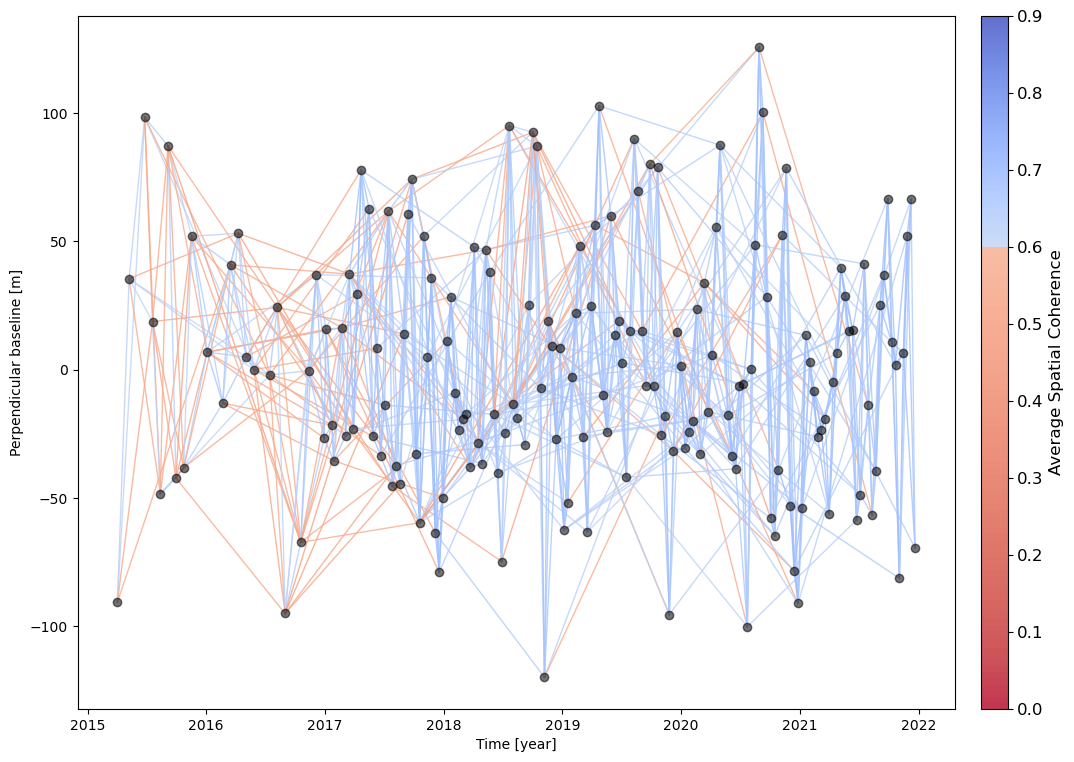

In [17]:
# Plot network graph
plot_network(aria_product.dataframe, min_coh=0, max_coh=0.9, coh_thresh=0.6)

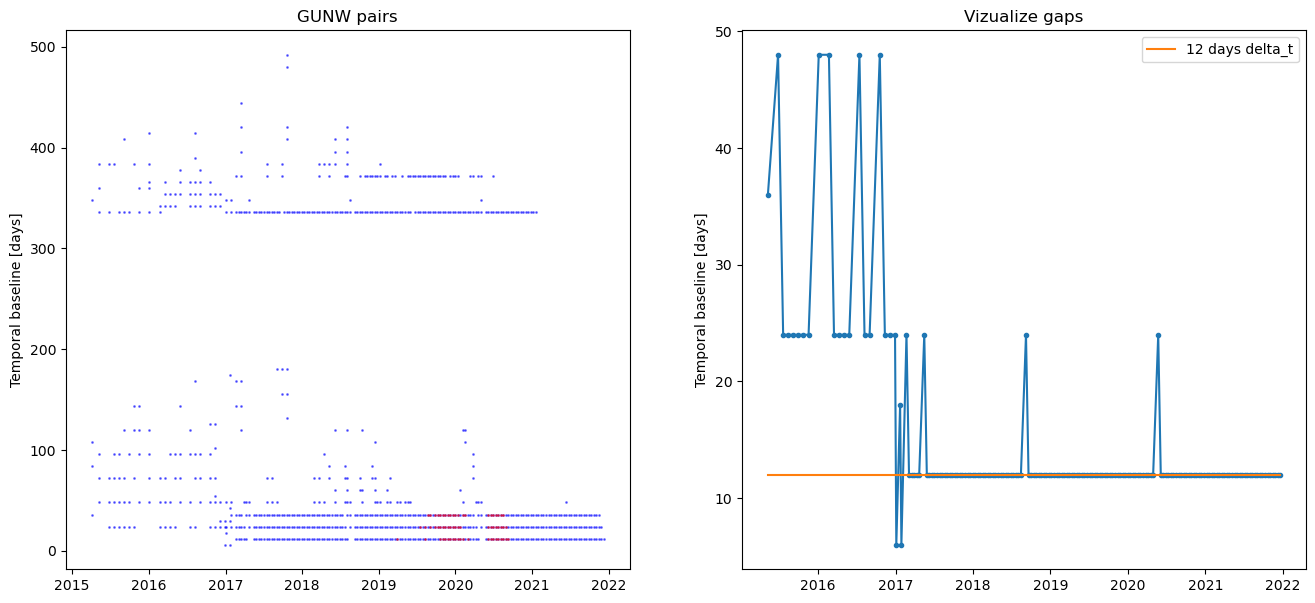

In [18]:
# Check for gaps in pairing and timeseries
fig, ax = plt.subplots(1,2, figsize=(16,7))
plot_pairing(aria_product.dataframe, color='blue', ax=ax[0])
plot_pairing(aria_product.df_duplicates, color='red',ax=ax[0])
plot_gaps(aria_product.dataframe, min_dt=12, ax=ax[1])

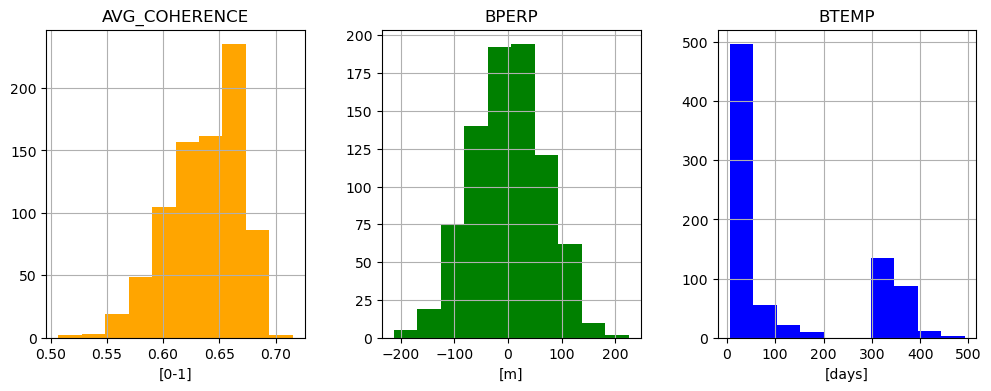

In [19]:
# Summary of stats
hist_stats(aria_product.dataframe)


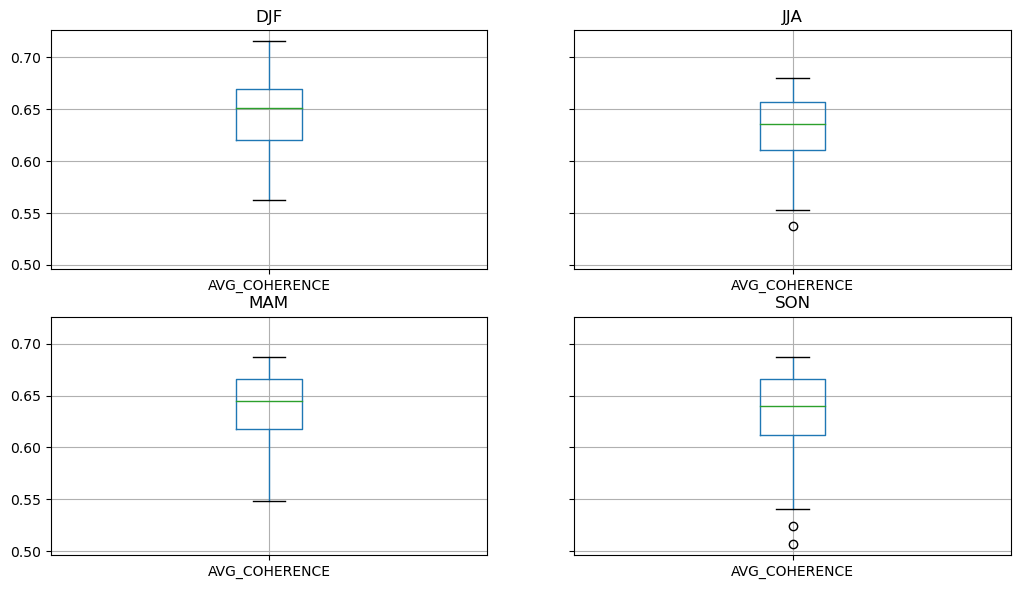

In [20]:
# Check avg coherence per season
hist_stats(aria_product.dataframe, season_boxplot=True)

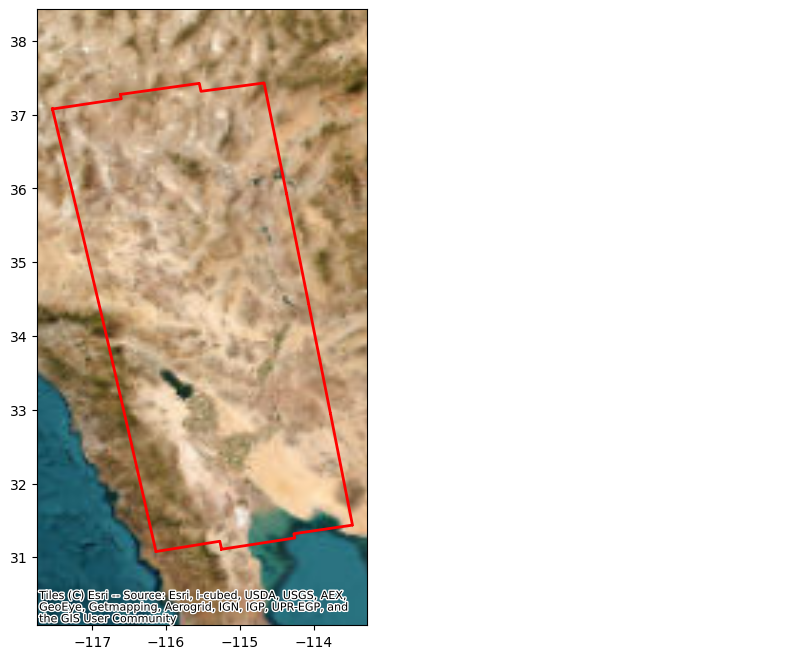

In [31]:
# Vizualize gunws extent
gdf_date12 = aria_product.get_df_date12(aria_product.dataframe)
extent = get_union_extent(gdf_date12)

# Plot
fig, ax = plt.subplots(1, figsize=(6,8))
ax.plot(*gdf_date12.unary_union.exterior.xy, c='red', lw=2)
ax.set_ylim([extent[1] -1, extent[3] + 1])
cx.add_basemap(ax, zoom=5,
               source=cx.providers.Esri.WorldImagery,
               crs=gdf_date12.crs)

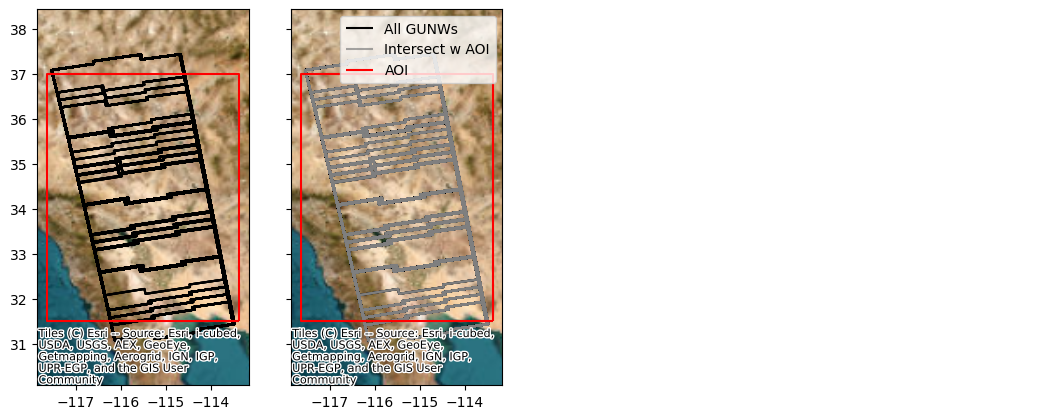

In [32]:
# DEFINE AOI LATITUDE EXTENT
# important later on for adjusting selection of gunw for export
# e.g min spatial coverage thresholding depends on the AOI area
# and only gunw that intersect with aoi will be processed

aria_product.find_aoi_intersection(south=31.5, north=37)

# convert aoi to geodataframe
poly_gdf = gpd.GeoDataFrame([1], geometry=[aria_product.aoi],
                            crs=gdf_date12.crs)

#Plot
fig, ax = plt.subplots(1,2, figsize=(6,8), sharey=True)
gdf_date12.exterior.plot(color='black', ax=ax[0])
poly_gdf.exterior.plot(color='red', ax=ax[0])
ax[0].set_ylim([extent[1] -1, extent[3] + 1]) 
cx.add_basemap(ax[0], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs)

#Plot
aria_product.dataframe.exterior.plot(color='black', ax=ax[1], label='All GUNWs')
aria_product.dataframe_filt.exterior.plot(color='gray', alpha=0.7, ax=ax[1], label='Intersect w AOI')
poly_gdf.exterior.plot(color='red', ax=ax[1], label='AOI')
ax[1].set_ylim([extent[1] -1, extent[3] + 1])  
cx.add_basemap(ax[1], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs)
ax[1].legend()

Disconnected pairs along track
    Number of kept scenes: 820
    Number of rejected scenes: 0

Pairs not fulfilling coverage requirement
    Number of kept pairs: 795
    Number of rejected pairs: 25


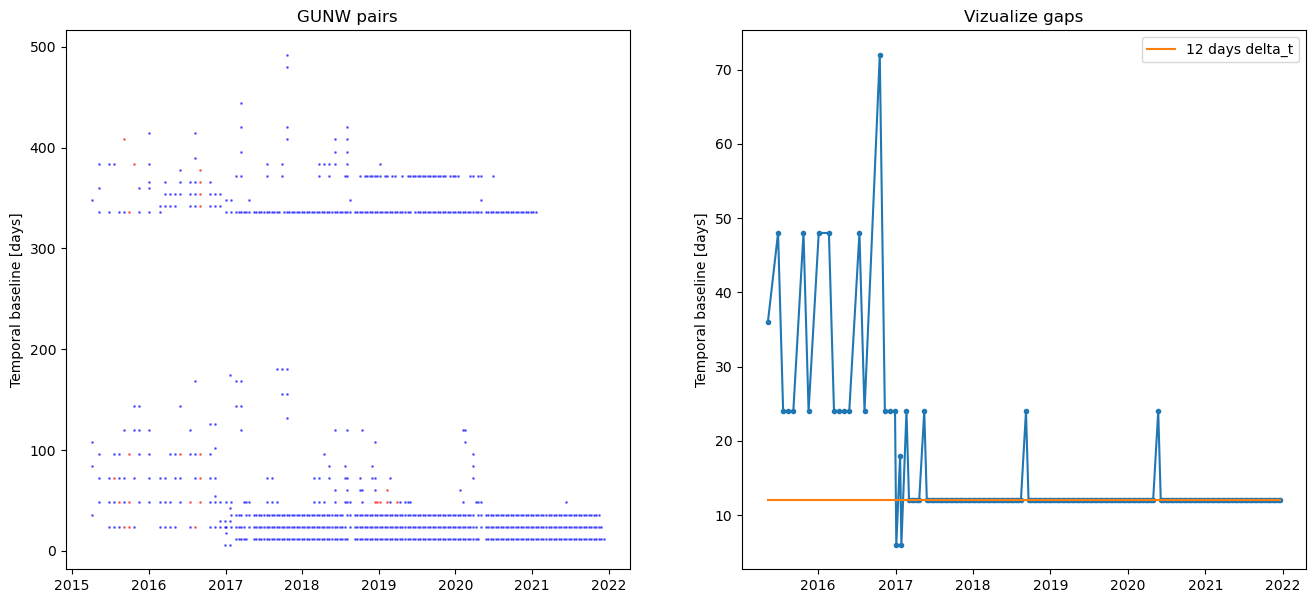

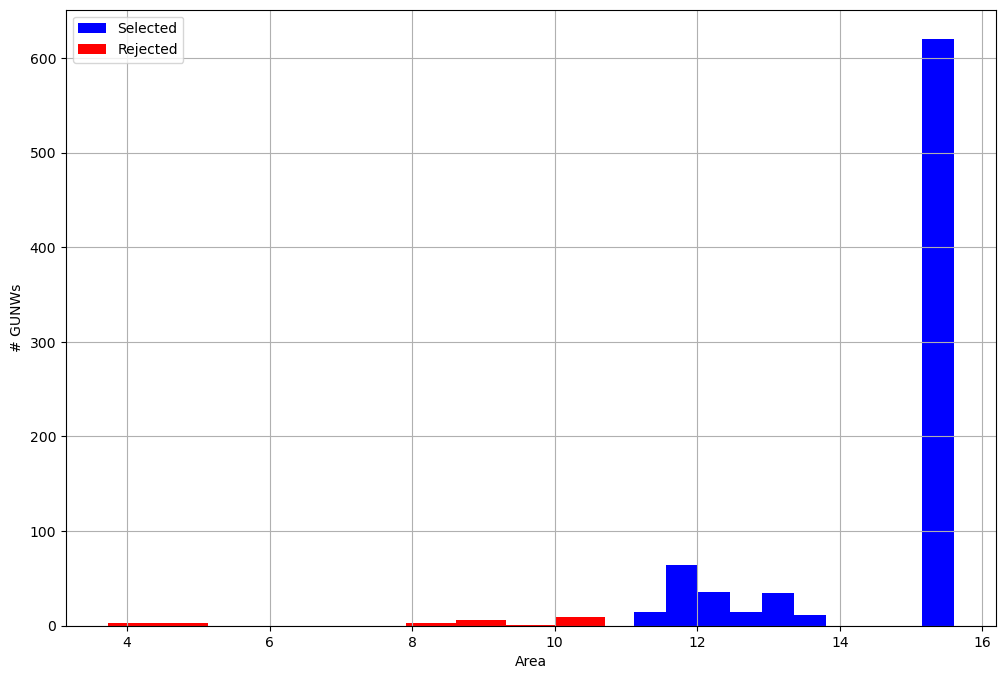

In [33]:
# Filter base on the minimum area coverage with respect to AOI
# e.g. 70 mean unary_inion of gunw for SAR acquisition date need to cover
# at least 70% of defined aoi
result = aria_product.filter_min_aoi_coverage(min_coverage_thresh=70)

# Get rejections
rejected = pd.concat([aria_product.df_rejected_aoi_coverage,
                      aria_product.df_rejected_disconnected])

fig, ax = plt.subplots(1,2, figsize=(16,7))
plot_pairing(aria_product.dataframe_fin, color='blue', ax=ax[0])
plot_pairing(rejected, color='red',ax=ax[0])
plot_gaps(aria_product.dataframe_fin, min_dt=12, ax=ax[1])

# Plot histograms
fig, ax = plt.subplots(1, figsize=(12,8))
result[0].area.hist(ax=ax, color='blue', label='Selected')
result[1].area.hist(ax=ax, color='red', label='Rejected')
ax.set_xlabel('Area')
ax.set_ylabel('# GUNWs')
ax.legend()

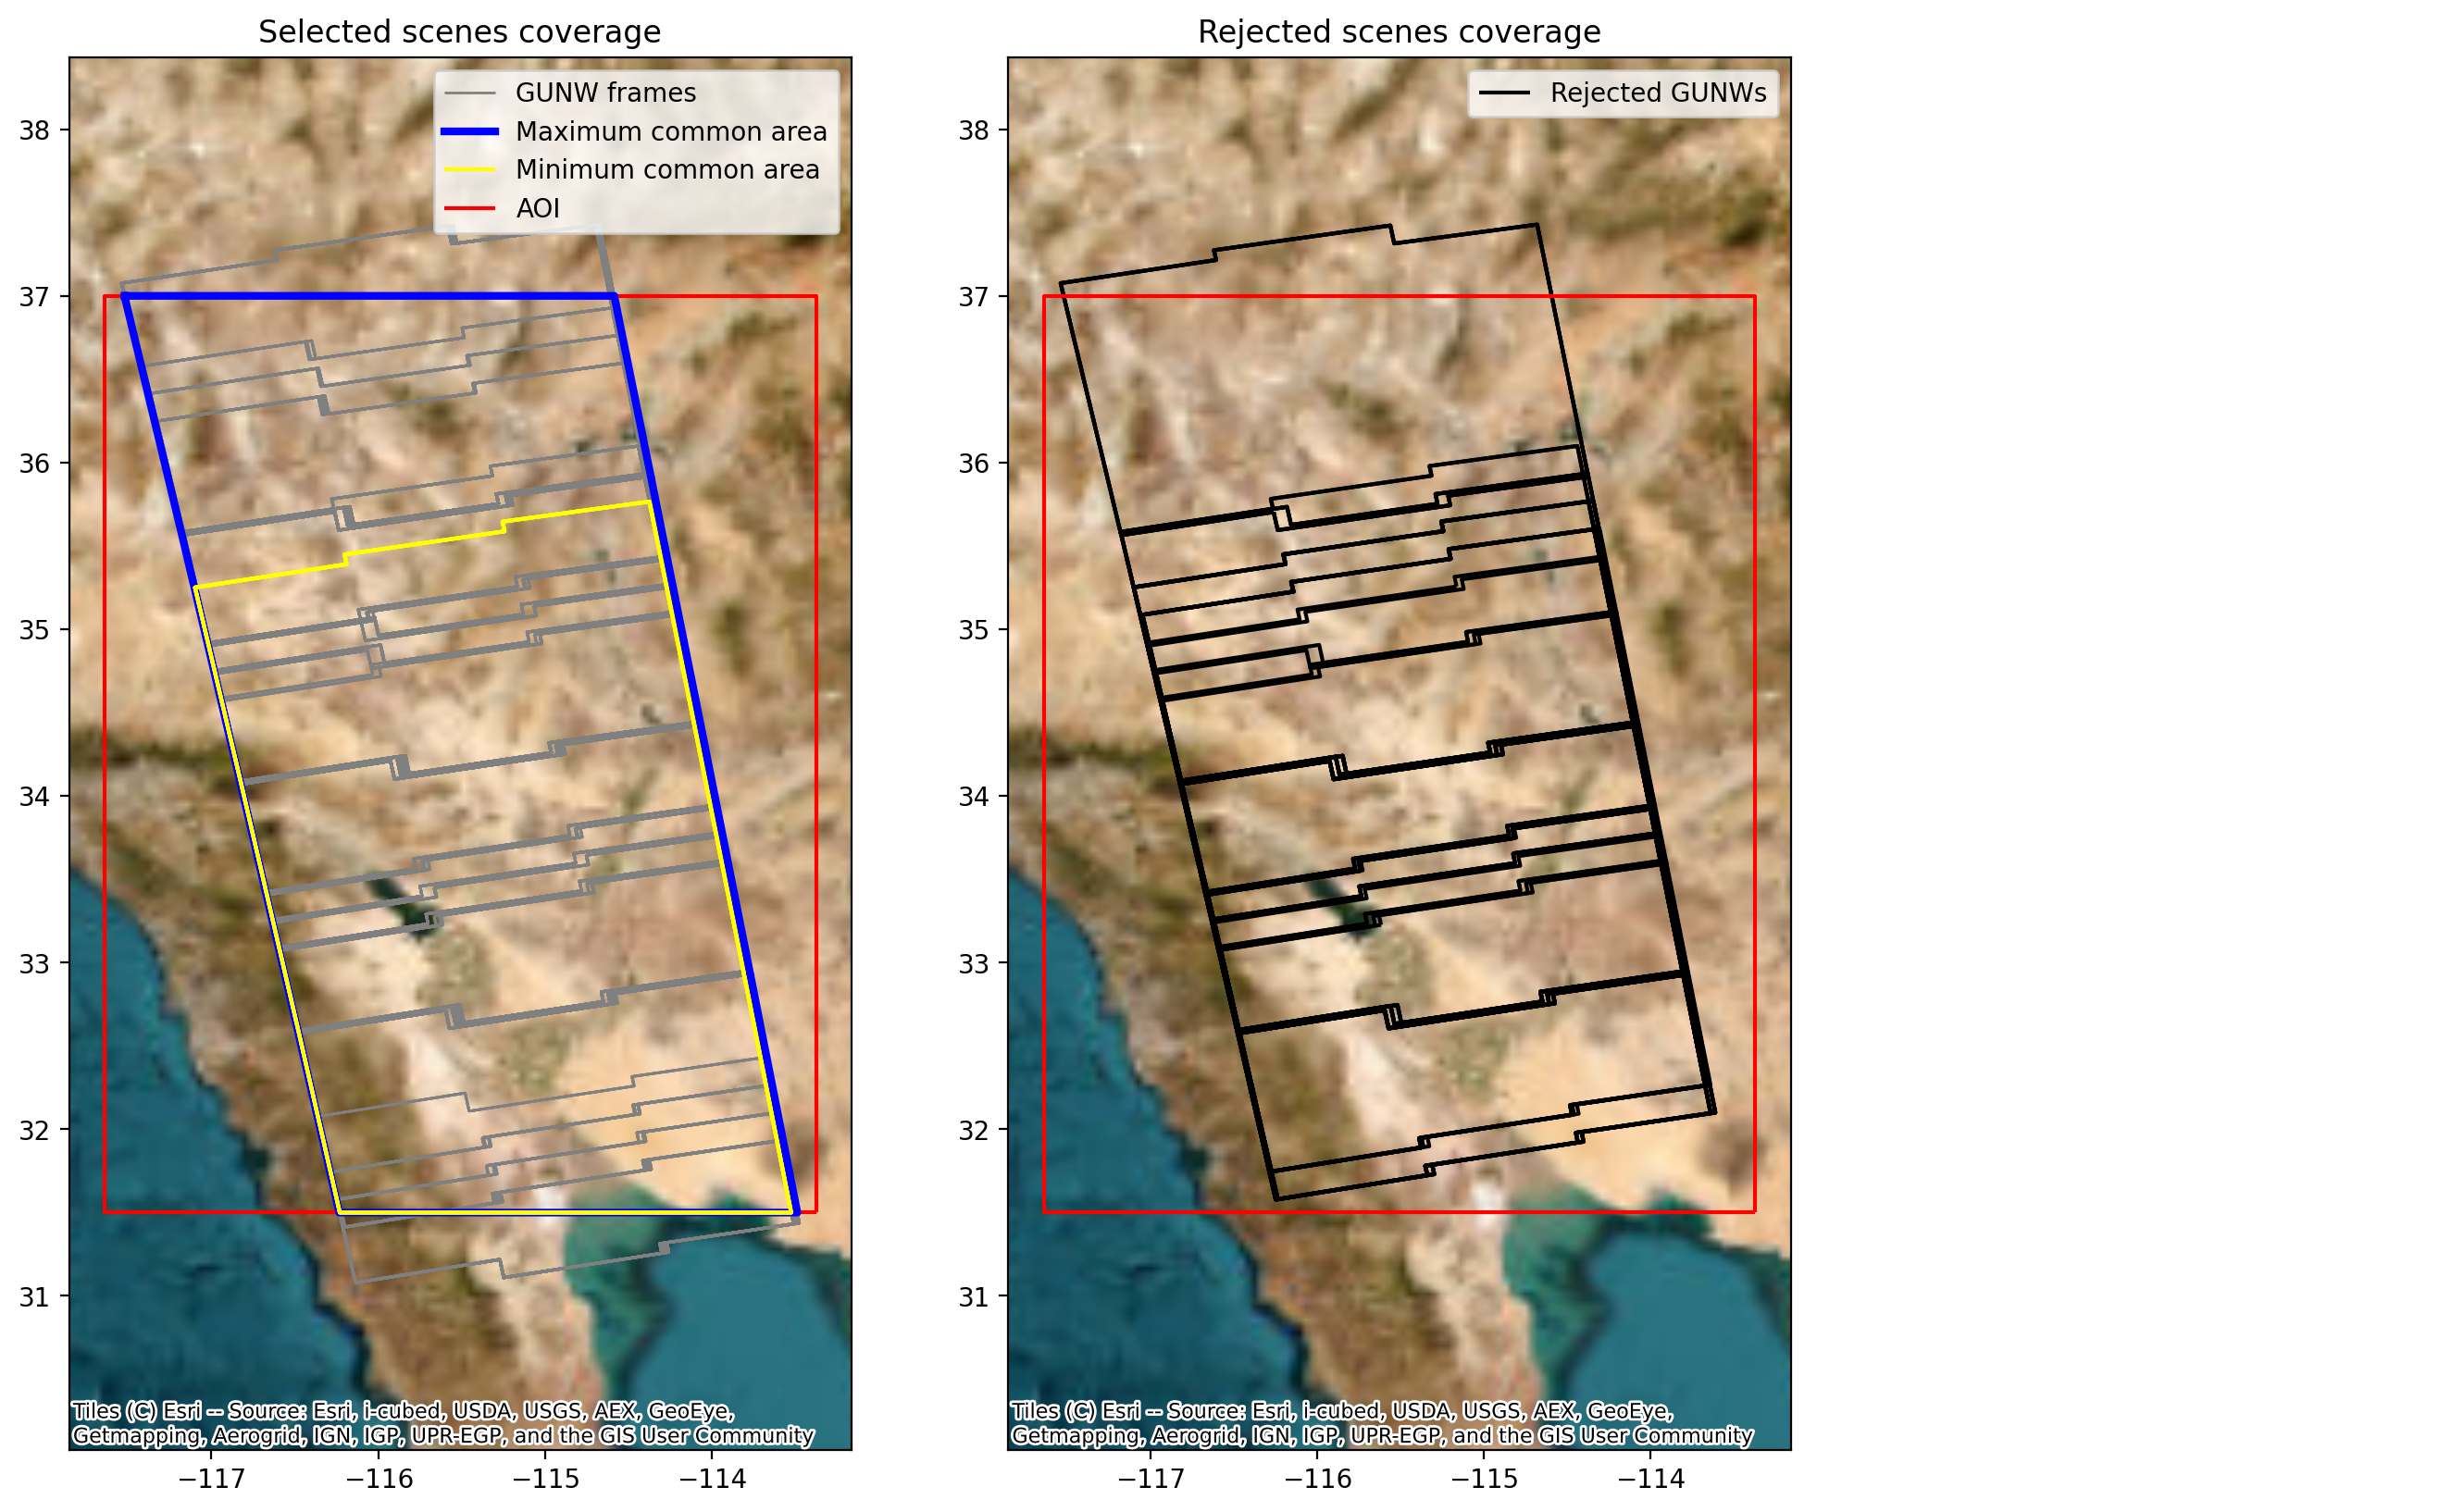

In [44]:
# PLOT selected and rejected scenes
fig, ax = plt.subplots(1,2, figsize=(12, 12), dpi=200)
aria_product.dataframe_fin.exterior.plot(color='gray', lw=1, ax=ax[0], label='GUNW frames')
ax[0].plot(*result[0].unary_union.exterior.xy, c='blue', lw=3, label='Maximum common area', zorder=4)
result[0][result[0].area == result[0].area.min()].exterior.plot(color='yellow',
                                                                ax=ax[0],
                                                                label='Minimum common area', zorder=4)
poly_gdf.exterior.plot(color='red', ax=ax[0], label='AOI', zorder=3)
cx.add_basemap(ax[0], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs)
ax[0].set_title('Selected scenes coverage')
ax[0].legend()

aria_product.df_rejected_aoi_coverage.exterior.plot(color='black',
                                                    ax=ax[1],
                                                    label='Rejected GUNWs')
poly_gdf.exterior.plot(color='red', ax=ax[1])
cx.add_basemap(ax[1], zoom=5, source=cx.providers.Esri.WorldImagery,
               crs=gdf_date12.crs)
ax[1].set_title('Rejected scenes coverage')
ax[0].set_ylim([extent[1] -1, extent[3] + 1]) 
ax[1].set_ylim([extent[1] -1, extent[3] + 1])
ax[1].legend() 

<AxesSubplot: >

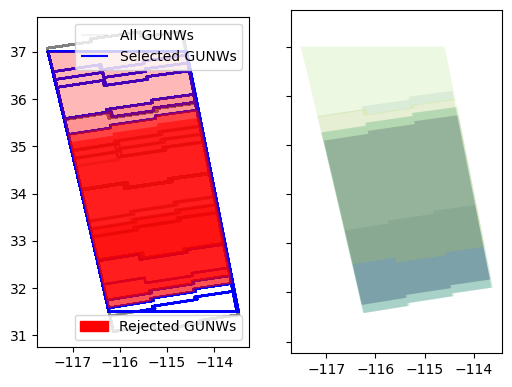

In [52]:
import matplotlib.patches as mpatches

gdf_date12 =aria_product.get_df_date12(aria_product.dataframe_fin)

# Plot unary union of rejected dates
fig, ax = plt.subplots(1,2, figsize=(6,8), sharey=True)
gdf_date12.exterior.plot(color='gray', ax=ax[0], alpha=0.1, zorder=0, label='All GUNWs')
result[0].exterior.plot(color='blue', ax=ax[0], zorder=1, label='Selected GUNWs')
result[1].plot(color='red', ax=ax[0], zorder=2, alpha=0.1)
first_legend = ax[0].legend()
ax[0].add_artist(first_legend)
red_patch = mpatches.Patch(color='red', label='Rejected GUNWs')
ax[0].legend(handles=[red_patch], loc='lower right')

# Check per date
result[1].plot(column='DATE1_DATE2', cmap='viridis', 
               alpha=0.05, ax=ax[1])

Number of SAR scenes: 168
Number of GUNWs:  795
Number of rejected GUNWs: 56


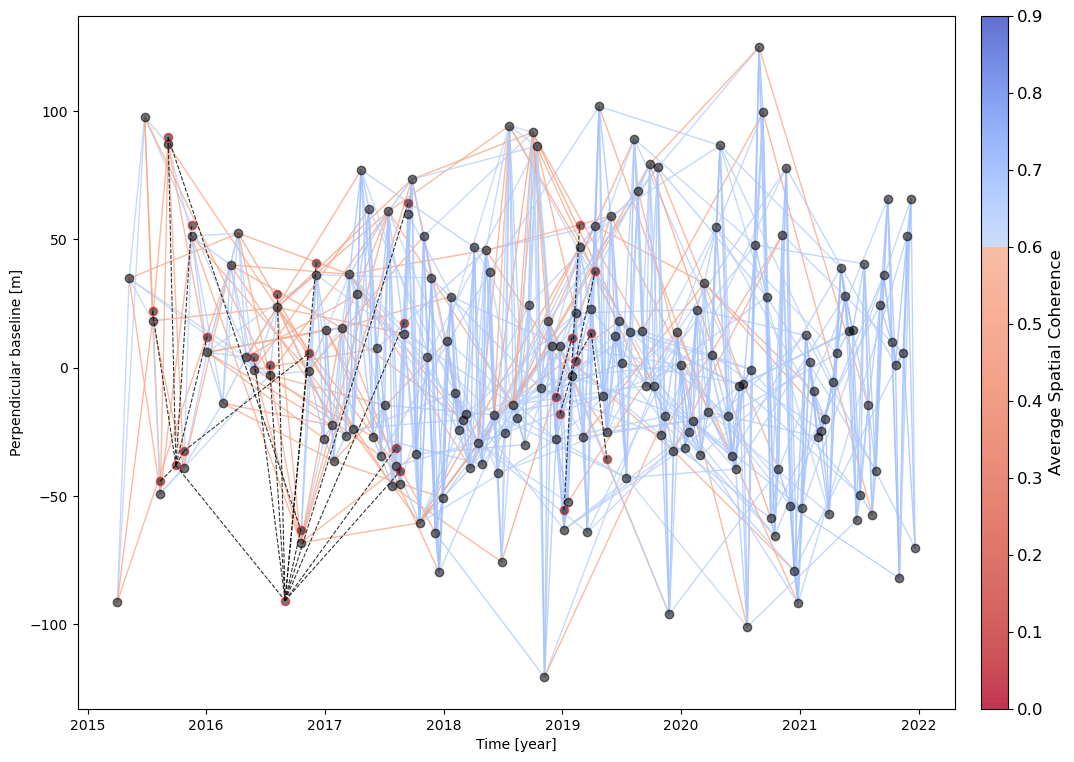

In [54]:
# PLOT final network
rejected = pd.concat([aria_product.df_rejected_aoi_coverage,
                      aria_product.df_rejected_disconnected])
plot_network(aria_product.dataframe_fin,
             min_coh=0, max_coh=0.9,
             coh_thresh=0.6, rejected_df=rejected)
print(f'Number of rejected GUNWs: {rejected.shape[0]}')

In [55]:
# Get scenes and number of frames after filtering
aria_product.dataframe_fin.groupby(['DATE2','DATE1'])['TRACK'].count().reset_index()

DATE2      DATE1  TRACK
0   2015-04-03 2015-05-09      3
1   2015-04-03 2015-06-26      3
2   2015-04-03 2015-07-20      3
3   2015-04-03 2016-03-16      3
4   2015-05-09 2015-06-26      3
..         ...        ...    ...
790 2021-11-15 2021-12-09      4
791 2021-11-15 2021-12-21      4
792 2021-11-27 2021-12-09      4
793 2021-11-27 2021-12-21      4
794 2021-12-09 2021-12-21      4

[795 rows x 3 columns]

In [56]:
# Get stats per aquisition date
scenes2export = get_df_d12stats(aria_product.dataframe_fin)
scenes2export

DATE2      DATE1  AVG_COHERENCE       BPERP  BTEMP SEASON
0   2015-04-03 2015-05-09       0.618012  125.962059   36.0    MAM
1   2015-04-03 2015-06-26       0.606314  189.218887   84.0    MAM
2   2015-04-03 2015-07-20       0.578240  109.597084  108.0    MAM
3   2015-04-03 2016-03-16       0.597892  131.185379  348.0    MAM
4   2015-05-09 2015-06-26       0.609778   63.327526   48.0    MAM
..         ...        ...            ...         ...    ...    ...
790 2021-11-15 2021-12-09       0.673666   60.098526   24.0    SON
791 2021-11-15 2021-12-21       0.670861  -76.006187   36.0    SON
792 2021-11-27 2021-12-09       0.681509   14.254930   12.0    SON
793 2021-11-27 2021-12-21       0.665749 -121.940300   24.0    SON
794 2021-12-09 2021-12-21       0.637638 -136.110428   12.0    DJF

[795 rows x 6 columns]

## REFINE SELECTION BASED ON SOME CRITERIA

In [57]:
# PLACEHOLDER FOR MIDNIGHT CROSSING
'''
delta_t = np.diff(np.sort(gunw_df.DATE1.unique())).astype('timedelta64[D]')
np.sort(gunw_df.DATE1.unique())[np.r_[False, delta_t < timedelta(days=2)]]

delta_t = np.diff(np.sort(gunw_df.DATE2.unique())).astype('timedelta64[D]')
np.sort(gunw_df.DATE2.unique())[np.r_[False, delta_t < timedelta(days=2)]]
'''

"\ndelta_t = np.diff(np.sort(gunw_df.DATE1.unique())).astype('timedelta64[D]')\nnp.sort(gunw_df.DATE1.unique())[np.r_[False, delta_t < timedelta(days=2)]]\n\ndelta_t = np.diff(np.sort(gunw_df.DATE2.unique())).astype('timedelta64[D]')\nnp.sort(gunw_df.DATE2.unique())[np.r_[False, delta_t < timedelta(days=2)]]\n"

In [58]:
# filter based on season
# JOIN DATE1 and DATE2 in DATE1_DATE2 to compare with dataframe_fin
scenes2export = get_df_d12stats(aria_product.dataframe_fin)
scenes2export = scenes2export[scenes2export.SEASON == 'MAM']
scenes2export

DATE2      DATE1  AVG_COHERENCE       BPERP  BTEMP SEASON
0   2015-04-03 2015-05-09       0.618012  125.962059   36.0    MAM
1   2015-04-03 2015-06-26       0.606314  189.218887   84.0    MAM
2   2015-04-03 2015-07-20       0.578240  109.597084  108.0    MAM
3   2015-04-03 2016-03-16       0.597892  131.185379  348.0    MAM
4   2015-05-09 2015-06-26       0.609778   63.327526   48.0    MAM
..         ...        ...            ...         ...    ...    ...
744 2021-05-19 2021-06-12       0.676318  -14.158134   24.0    MAM
745 2021-05-19 2021-06-24       0.653152  -86.937759   36.0    MAM
746 2021-05-31 2021-06-12       0.681366    1.585790   12.0    MAM
747 2021-05-31 2021-06-24       0.658528  -73.120216   24.0    MAM
748 2021-05-31 2021-07-06       0.651964  -63.469414   36.0    MAM

[208 rows x 6 columns]

In [59]:
# This could be valuable to check number of conncetion per date to kick out dates with only 1 connection
scenes2export.groupby(['DATE1', "DATE2"], group_keys=True).apply(lambda x: x) #.index.levels[0]

DATE2      DATE1  AVG_COHERENCE       BPERP  \
DATE1      DATE2                                                             
2015-05-09 2015-04-03 0   2015-04-03 2015-05-09       0.618012  125.962059   
2015-06-26 2015-04-03 1   2015-04-03 2015-06-26       0.606314  189.218887   
           2015-05-09 4   2015-05-09 2015-06-26       0.609778   63.327526   
2015-07-20 2015-04-03 2   2015-04-03 2015-07-20       0.578240  109.597084   
           2015-05-09 5   2015-05-09 2015-07-20       0.601175  -16.945744   
...                              ...        ...            ...         ...   
2021-06-12 2021-05-19 744 2021-05-19 2021-06-12       0.676318  -14.158134   
           2021-05-31 746 2021-05-31 2021-06-12       0.681366    1.585790   
2021-06-24 2021-05-19 745 2021-05-19 2021-06-24       0.653152  -86.937759   
           2021-05-31 747 2021-05-31 2021-06-24       0.658528  -73.120216   
2021-07-06 2021-05-31 748 2021-05-31 2021-07-06       0.651964  -63.469414   

                           BTEMP SEASON  
DATE1      DATE2                         
2015-05-09 2015-04-03 0     36.0    MAM  
2015-06-26 2015-04-03 1     84.0    MAM  
           2015-05-09 4     48.0    MAM  
2015-07-20 2015-04-03 2    108.0    MAM  
           2015-05-09 5     72.0    MAM  
...                          ...    ...  
2021-06-12 2021-05-19 744   24.0    MAM  
           2021-05-31 746   12.0    MAM  
2021-06-24 2021-05-19 745   36.0    MAM  
           2021-05-31 747   24.0    MAM  
2021-07-06 2021-05-31 748   36.0    MAM  

[208 rows x 6 columns]

In [60]:
# This could be valuable to check number of conncetion per date to kick out dates with only 1 connection
scenes2export.groupby(['DATE1', "DATE2"], group_keys=True).apply(lambda x: x)#.index.levels[0]

DATE2      DATE1  AVG_COHERENCE       BPERP  \
DATE1      DATE2                                                             
2015-05-09 2015-04-03 0   2015-04-03 2015-05-09       0.618012  125.962059   
2015-06-26 2015-04-03 1   2015-04-03 2015-06-26       0.606314  189.218887   
           2015-05-09 4   2015-05-09 2015-06-26       0.609778   63.327526   
2015-07-20 2015-04-03 2   2015-04-03 2015-07-20       0.578240  109.597084   
           2015-05-09 5   2015-05-09 2015-07-20       0.601175  -16.945744   
...                              ...        ...            ...         ...   
2021-06-12 2021-05-19 744 2021-05-19 2021-06-12       0.676318  -14.158134   
           2021-05-31 746 2021-05-31 2021-06-12       0.681366    1.585790   
2021-06-24 2021-05-19 745 2021-05-19 2021-06-24       0.653152  -86.937759   
           2021-05-31 747 2021-05-31 2021-06-24       0.658528  -73.120216   
2021-07-06 2021-05-31 748 2021-05-31 2021-07-06       0.651964  -63.469414   

                           BTEMP SEASON  
DATE1      DATE2                         
2015-05-09 2015-04-03 0     36.0    MAM  
2015-06-26 2015-04-03 1     84.0    MAM  
           2015-05-09 4     48.0    MAM  
2015-07-20 2015-04-03 2    108.0    MAM  
           2015-05-09 5     72.0    MAM  
...                          ...    ...  
2021-06-12 2021-05-19 744   24.0    MAM  
           2021-05-31 746   12.0    MAM  
2021-06-24 2021-05-19 745   36.0    MAM  
           2021-05-31 747   24.0    MAM  
2021-07-06 2021-05-31 748   36.0    MAM  

[208 rows x 6 columns]

In [61]:
# filter based on temporal baseline
scenes2export = aria_product.dataframe_fin[aria_product.dataframe_fin['BTEMP'] < 16]
get_df_d12stats(scenes2export)

DATE2      DATE1  AVG_COHERENCE       BPERP  BTEMP SEASON
0   2016-12-29 2017-01-04       0.673125   43.025425    6.0    DJF
1   2017-01-22 2017-01-28       0.658271  -18.074572    6.0    DJF
2   2017-02-21 2017-03-05       0.648298  -42.056896   12.0    DJF
3   2017-03-05 2017-03-17       0.670475   62.490681   12.0    MAM
4   2017-03-17 2017-03-29       0.672108  -60.562958   12.0    MAM
..         ...        ...            ...         ...    ...    ...
138 2021-10-22 2021-11-03       0.678114  -84.413094   12.0    SON
139 2021-11-03 2021-11-15       0.676908   87.595055   12.0    SON
140 2021-11-15 2021-11-27       0.676153   45.953701   12.0    SON
141 2021-11-27 2021-12-09       0.681509   14.254930   12.0    SON
142 2021-12-09 2021-12-21       0.637638 -136.110428   12.0    DJF

[143 rows x 6 columns]

# EXPORT PRODUCTS WITH DASK

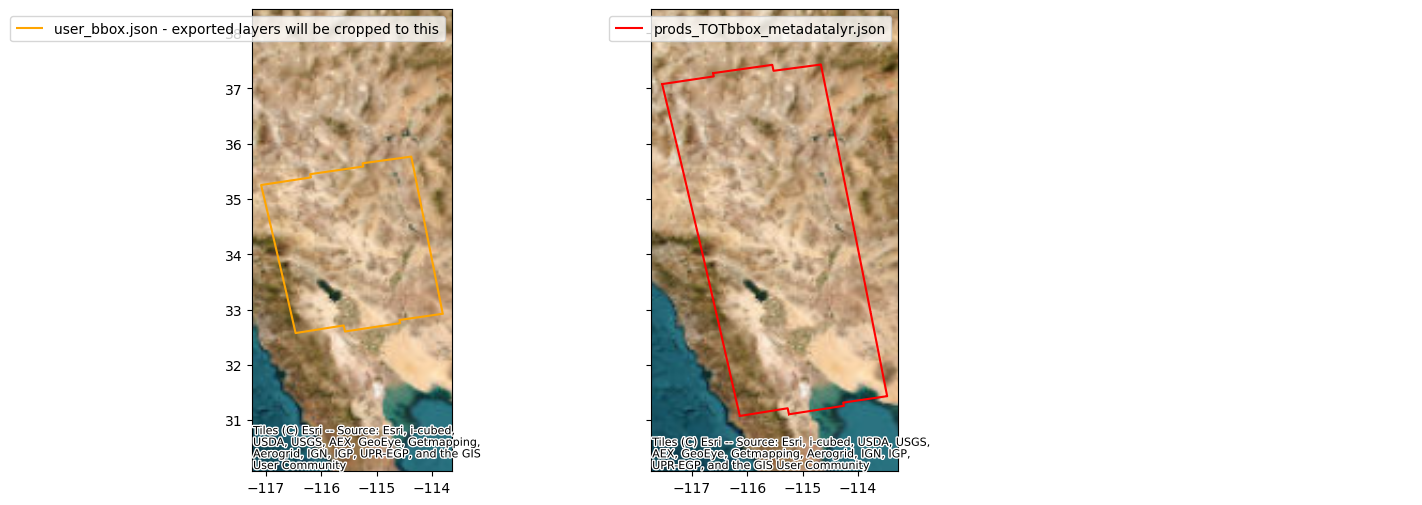

In [64]:
# Save aoi box for exporting
aria_product.save_aria_bbox()

#Lets double check the aoi 
geo_bbox = gpd.read_file(aria_product.user_json)
geo_bbox1 = gpd.read_file(aria_product.product_json)

fig, ax = plt.subplots(1,2, figsize=(10, 6), sharey=True)
geo_bbox.exterior.plot(ax=ax[0], color='orange',
                       label='user_bbox.json - exported layers will be cropped to this')
geo_bbox1.exterior.plot(ax=ax[1], color='red',
                        label='prods_TOTbbox_metadatalyr.json')
cx.add_basemap(ax[0], zoom=5,
              source=cx.providers.Esri.WorldImagery,
              crs='EPSG:4326', zorder=0)
cx.add_basemap(ax[1], zoom=5, 
               source=cx.providers.Esri.WorldImagery,
               crs='EPSG:4326', zorder=0)
ax[0].set_ylim([extent[1] -1, extent[3] + 1]) 
ax[1].set_ylim([extent[1] -1, extent[3] + 1]) 
for a in ax: a.legend()

## prepare auxiliary fo export

In [65]:
# 1. Generate product distionary of selected GUNWs for export
aria_product.generate_product_dict()

In [70]:
# Prepare dem and water mask
# NOTE include check of user_bbox.json, if modify overwrite exported files
aria_product.prepare_dem(dem_option='download')
aria_product.prepare_watermask(mask_option='download')

Applied cutline to produce 3 arc-sec Copernicus GLO90 DEM: /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/A166/ARIA/DEM/glo_90.dem
***Downloading water mask... ***


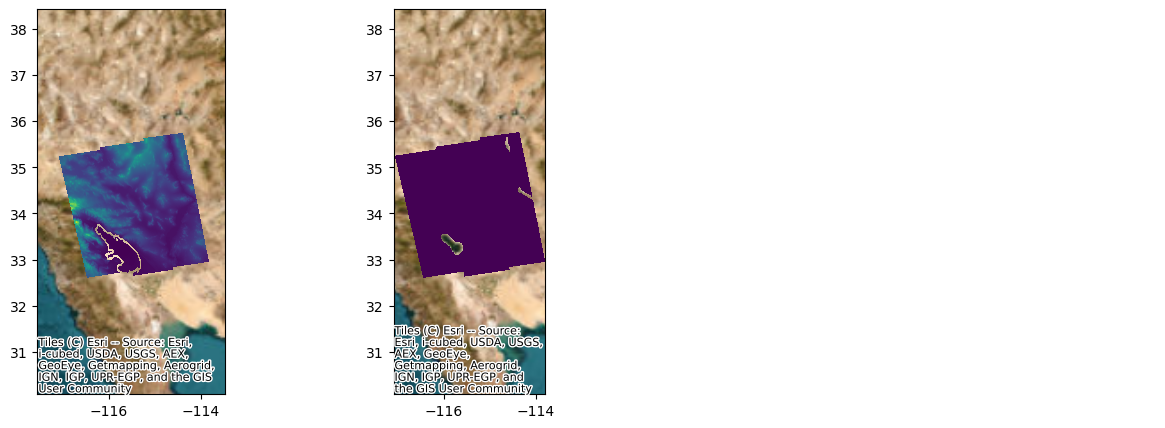

In [71]:
# Open mask file
mask = gdal.Open(aria_product.mask)
mask_extent = ds_get_extent(mask)

# PLOT TO VERIFY DEM AND WATER MASK
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(np.ma.masked_equal(aria_product.dem.ReadAsArray(), 0),
             extent=aria_product.dem_extent, zorder=1)
ax[0].set_ylim([extent[1] -1, extent[3] + 1]) 
cx.add_basemap(ax[0], zoom=5,
               source=cx.providers.Esri.WorldImagery,
               crs='EPSG:4326',
               zorder=0)

ax[1].imshow(np.ma.masked_equal(mask.ReadAsArray(), 0),
             extent=mask_extent, zorder=1)
ax[1].set_ylim([extent[1] -1, extent[3] + 1]) 
cx.add_basemap(ax[1], zoom=5,
               source=cx.providers.Esri.WorldImagery,
               crs='EPSG:4326',
               zorder=0)

## export layers

In [72]:
%%time
# export unwrapped phase
# mask_conn0 - to mask phase under the connected component 0 
#              [unreliable unwrapped phase by snaphu]
aria_product.export_layers(layer='unwrappedPhase', n_jobs=30, mask_conn0=True)

Running GUNW unwrappedPhase and connectedComponents in parallel!
Link: http://127.0.0.1:8787/status
Run 795 jobs with 30 workers.


In [ ]:
%%time
# export coherence
aria_product.export_layers(layer='coherence', n_jobs=30)

In [ ]:
%%time
# export imaging geometry
aria_product.export_layers(layer='incidenceAngle', n_jobs=1)
aria_product.export_layers(layer='azimuthAngle', n_jobs=1)
aria_product.export_layers(layer='bPerpendicular', n_jobs=1)

In [ ]:
# Read perpdincular baseline text file
pd.read_csv(aria_product.aria_dir / 'stack_stats.csv')

# GENERATE STACK AND PREPARE MINTPY INPUTS

In [ ]:
aria_product.prepare_stack()

In [ ]:
aria_product.prep_mintpy()